In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, Attention, Input, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

data = pd.read_csv('/content/updated_fault_detection_synthetic_data_2021_2023.csv')
data['Type of Fault'] = data['Type of Fault'].map({'No Fault': 0, 'Imbalance': 1, 'Overcurrent': 2, 'Undervoltage': 3, 'Overvoltage': 4})

data.head()

,Unnamed: 0,Voltage Levels (V),Current Levels (A),Frequency (Hz),Power Factor,Harmonics (%),Phase Angles (deg),Voltage Imbalance (%),Current Imbalance (%),Circuit Breaker Status,...,Breaker Failure Relay Status,Transformer Ambient Temperature (C),Vibration Sensors (Transformers) (mm/s),Predictive Maintenance Indicators,Transformer DGA Data (ppm),Partial Discharge Monitoring (pC),Equipment Health Index (%),Fault Locator Data (km),Type of Fault,Magnitude of Fault
0,2021-01-01 00:00:00,233.975671,23.459695,50.310752,0.970945,1.147168,340.954554,0.822754,0.334818,0,...,1,25.861757,2.130951,0,91.741067,12.500386,99.896644,37.525688,0,Minor
1,2021-01-01 01:00:00,224.620108,34.625158,49.878147,0.852839,4.312127,76.710516,1.173052,1.161149,1,...,1,-9.110370,3.709835,0,39.795588,47.620850,83.825707,8.873906,1,Moderate
2,2021-01-01 02:00:00,224.140034,29.021422,50.477939,0.996591,1.771850,114.615811,1.994294,0.722321,1,...,0,32.944269,0.584877,0,31.331521,42.201478,85.682569,3.109018,1,Severe
3,2021-01-01 03:00:00,230.199204,41.634432,50.216238,0.896829,0.556320,190.493416,0.455552,1.085936,0,...,1,-4.278324,3.438980,1,67.645083,16.287280,80.466026,30.722904,2,Moderate
4,2021-01-01 04:00:00,228.446964,45.918278,50.075705,0.948779,2.614954,213.757928,1.519676,1.933942,0,...,0,18.986756,2.667889,1,25.182159,60.545391,95.861414,33.095610,2,Moderate


In [ ]:
data = data.drop(['Unnamed: 0'], axis=1)

X = data.drop(['Type of Fault', 'Magnitude of Fault'], axis=1)
y_fault_type = data['Type of Fault']
y_fault_magnitude = data['Magnitude of Fault']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

onehot_encoder = OneHotEncoder(sparse_output=False)
y_fault_type_onehot = onehot_encoder.fit_transform(y_fault_type.values.reshape(-1, 1))

In [ ]:
# training, validation, and test sets
X_train, X_temp, y_fault_type_train, y_fault_type_temp, y_magnitude_train, y_magnitude_temp = train_test_split(
    X_scaled, y_fault_type_onehot, y_fault_magnitude, test_size=0.3, random_state=42)
X_val, X_test, y_fault_type_val, y_fault_type_test, y_magnitude_val, y_magnitude_test = train_test_split(
    X_temp, y_fault_type_temp, y_magnitude_temp, test_size=0.5, random_state=42)

In [ ]:
# Reshaping input data for LSTM
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_reshaped = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:

inputs = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
x = Bidirectional(LSTM(units=50, activation='tanh', return_sequences=True))(inputs)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=50, activation='tanh', return_sequences=True))(x)
x = Dropout(0.5)(x)
attention_output = Attention()([x, x])
pooled_output = GlobalAveragePooling1D()(attention_output)

# Output layers for classification of type and magnitude
output1 = Dense(5, activation='softmax', name='output1')(pooled_output)
output2 = Dense(3, activation='softmax', name='output2')(pooled_output)

# Build and compile model
rnn_model = Model(inputs=inputs, outputs=[output1, output2])

y_magnitude_train_encoded = y_magnitude_train.map({'Low': 0, 'Moderate': 1, 'High': 2}).fillna(0).astype(int)
y_magnitude_val_encoded = y_magnitude_val.map({'Low': 0, 'Moderate': 1, 'High': 2}).fillna(0).astype(int)

rnn_model.compile(optimizer=Adam(),
                  loss={'output1': 'categorical_crossentropy', 'output2': 'sparse_categorical_crossentropy'},
                  metrics={'output1': 'accuracy', 'output2': 'accuracy'})  # Corrected loss and metrics keys

trained_model = rnn_model.fit(X_train_reshaped,
                              {'output1': y_fault_type_train, 'output2': y_magnitude_train_encoded},
                              epochs=50, batch_size=64,
                              validation_data=(X_val_reshaped,
                                               {'output1': y_fault_type_val, 'output2': y_magnitude_val_encoded}),
                              verbose=1)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


288/288 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 2.0134 - output1_accuracy: 0.6280 - output2_accuracy: 0.6329 - val_loss: 0.7285 - val_output1_accuracy: 0.9117 - val_output2_accuracy: 0.7920
Epoch 2/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.7819 - output1_accuracy: 0.8815 - output2_accuracy: 0.7728 - val_loss: 0.5088 - val_output1_accuracy: 0.9282 - val_output2_accuracy: 0.8493
Epoch 3/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5805 - output1_accuracy: 0.9041 - output2_accuracy: 0.8487 - val_loss: 0.3408 - val_output1_accuracy: 0.9343 - val_output2_accuracy: 0.9348
Epoch 4/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.4350 - output1_accuracy: 0.9217 - output2_accuracy: 0.9046 - val_loss: 0.2533 - val_output1_accuracy: 0.9432 - val_output2_accuracy: 0.9688
Epoch 5/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.3612 - output1_accuracy: 0.9247 - output2_accuracy: 0.9336 - val_loss: 0.1986 - val_output1_accuracy: 0.9551 - val_output2_accuracy: 0.9795


In [ ]:

y_pred = rnn_model.predict(X_test_reshaped)

pred_fault_type = np.argmax(y_pred[0], axis=-1)
pred_fault_magnitude = np.argmax(y_pred[1], axis=-1) + 1  # Adjust for magnitude classes (1, 2, 3)

print("Fault Type Classification Report:")
print(classification_report(y_fault_type_test.argmax(axis=-1), pred_fault_type))


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Fault Type Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       474
           1       0.99      0.99      0.99      2450
           2       0.98      0.98      0.98       987
           3       1.00      1.00      1.00        15
           4       1.00      0.75      0.86        16

    accuracy                           0.99      3942
   macro avg       0.99      0.94      0.96      3942
weighted avg       0.99      0.99      0.99      3942



In [ ]:
print(pred_fault_type)

[2 1 1 ... 2 1 2]


In [ ]:
print(pred_fault_magnitude[:150])

[1 2 1 2 1 2 1 1 2 1 1 1 1 1 2 1 2 2 2 1 2 1 1 2 1 2 2 1 1 1 1 1 2 2 1 1 1
 2 2 2 1 1 2 1 2 2 1 2 1 2 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 2 1 2 1 2 1 1 1 2
 1 1 2 2 1 1 1 1 1 1 2 2 1 2 2 2 1 1 2 1 1 1 1 2 2 2 1 1 1 2 2 1 2 2 1 2 2
 1 1 1 2 1 2 2 2 1 1 1 1 1 2 1 1 1 2 1 2 1 1 2 1 2 2 2 1 1 2 1 1 1 1 2 1 1
 1 1]


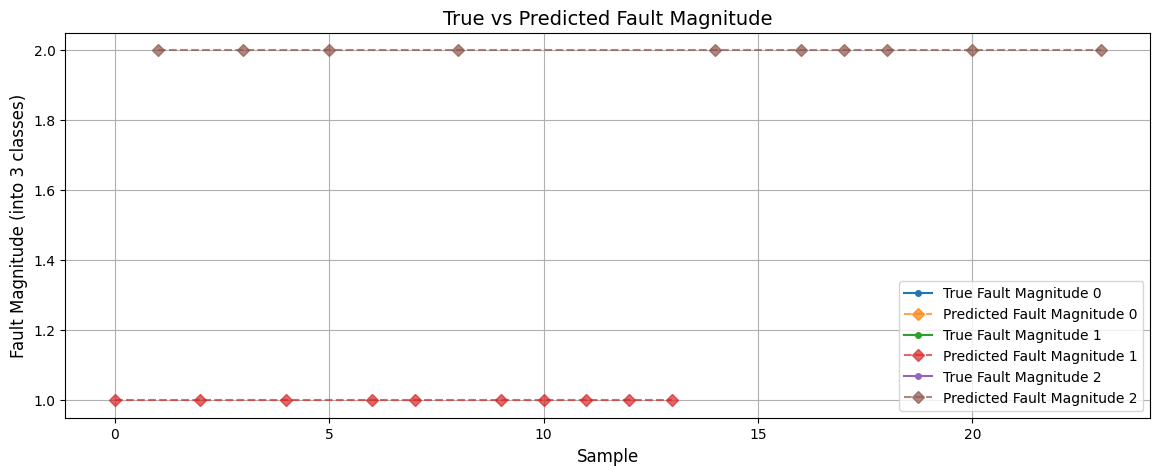

In [ ]:
import matplotlib.pyplot as plt

mag_of_fault = 3

plt.figure(figsize=(14, 5))

for i in range(mag_of_fault):
    true_indices = np.where(y_magnitude_test == i)[0][:10]
    true_values = np.array(y_magnitude_test)[true_indices]
    pred_indices = np.where(pred_fault_magnitude == i)[0][:10]
    pred_values = np.array(pred_fault_magnitude)[pred_indices]

    plt.plot(true_indices, true_values, label=f'True Fault Magnitude {i}', marker='o', linestyle='-', markersize=4)
    plt.plot(pred_indices, pred_values, label=f'Predicted Fault Magnitude {i}', marker='D', linestyle='--', alpha=0.7)

plt.title('True vs Predicted Fault Magnitude', fontsize=14)
plt.xlabel('Sample', fontsize=12)
plt.ylabel('Fault Magnitude (into 3 classes)', fontsize=12)

plt.legend(loc='best')
plt.grid(True)
plt.show()


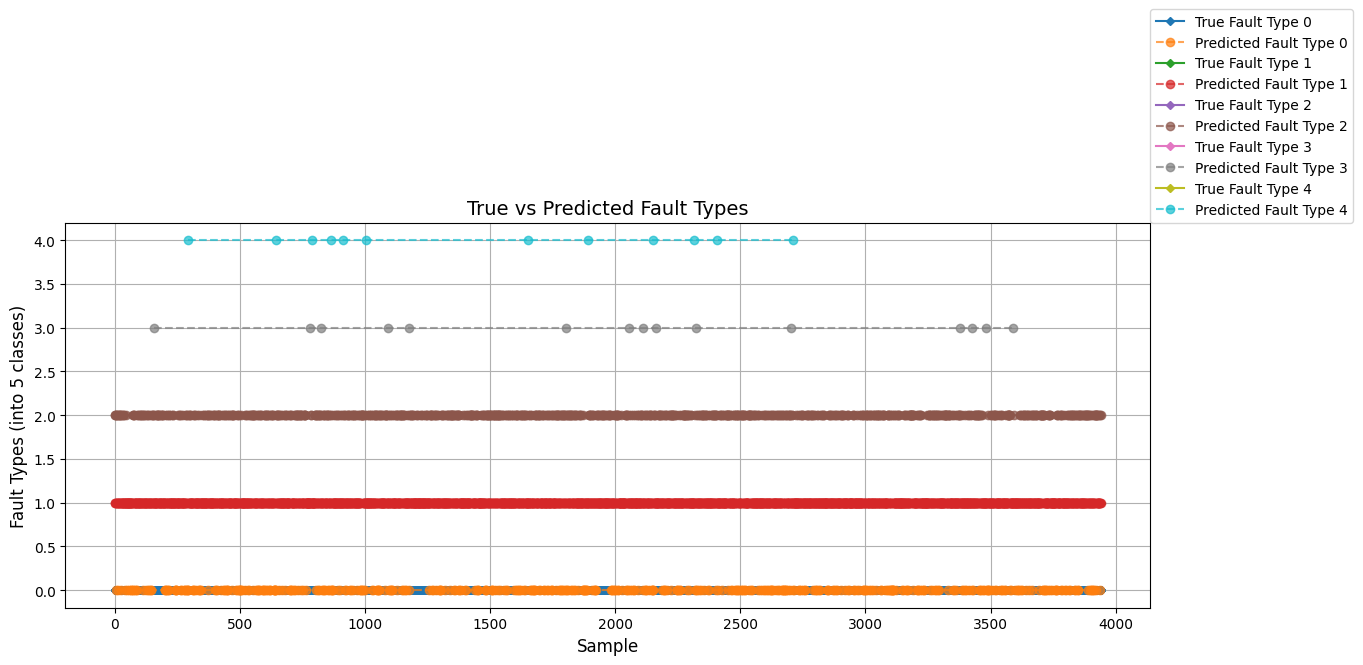

In [ ]:
fault_classes = 5

plt.figure(figsize=(14, 5))

for i in range(fault_classes):
    plt.plot(np.where(y_fault_type_test == i)[0], np.array(y_fault_type_test)[y_fault_type_test == i],
             label=f'True Fault Type {i}', marker='D', linestyle='-', markersize=4)

    plt.plot(np.where(pred_fault_type == i)[0], np.array(pred_fault_type)[pred_fault_type == i],
             label=f'Predicted Fault Type {i}', marker='o', linestyle='--', alpha=0.7)

plt.title('True vs Predicted Fault Types', fontsize=14)
plt.xlabel('Sample', fontsize=12)
plt.ylabel('Fault Types (into 5 classes)', fontsize=12)

plt.legend(loc=(1, 1))
plt.grid(True)
plt.show()


In [ ]:
import joblib

joblib.dump(rnn_model, 'rnn_model.joblib')

['rnn_model.joblib']

In [ ]:
import pickle
pickle.dump(rnn_model,open('rnn_model.pickle',"wb"))

In [ ]:
joblib.dump(data.columns,"Fault_data_col.joblib")

['Fault_data_col.joblib']

In [ ]:
data.head()

,Voltage Levels (V),Current Levels (A),Frequency (Hz),Power Factor,Harmonics (%),Phase Angles (deg),Voltage Imbalance (%),Current Imbalance (%),Circuit Breaker Status,Circuit Breaker Health (%),...,Breaker Failure Relay Status,Transformer Ambient Temperature (C),Vibration Sensors (Transformers) (mm/s),Predictive Maintenance Indicators,Transformer DGA Data (ppm),Partial Discharge Monitoring (pC),Equipment Health Index (%),Fault Locator Data (km),Type of Fault,Magnitude of Fault
0,233.975671,23.459695,50.310752,0.970945,1.147168,340.954554,0.822754,0.334818,0,97.895322,...,1,25.861757,2.130951,0,91.741067,12.500386,99.896644,37.525688,0,Minor
1,224.620108,34.625158,49.878147,0.852839,4.312127,76.710516,1.173052,1.161149,1,86.064089,...,1,-9.110370,3.709835,0,39.795588,47.620850,83.825707,8.873906,1,Moderate
2,224.140034,29.021422,50.477939,0.996591,1.771850,114.615811,1.994294,0.722321,1,91.327535,...,0,32.944269,0.584877,0,31.331521,42.201478,85.682569,3.109018,1,Severe
3,230.199204,41.634432,50.216238,0.896829,0.556320,190.493416,0.455552,1.085936,0,97.428452,...,1,-4.278324,3.438980,1,67.645083,16.287280,80.466026,30.722904,2,Moderate
4,228.446964,45.918278,50.075705,0.948779,2.614954,213.757928,1.519676,1.933942,0,96.407141,...,0,18.986756,2.667889,1,25.182159,60.545391,95.861414,33.095610,2,Moderate
